# Introduction

In [1]:
# change into root directory to the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy 

import glob

from neurolib.models.aln import ALNModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['image.cmap'] = 'plasma'

# Single node simulation

In [4]:
aln = ALNModel()
aln.params['duration'] = 10.0*1000
aln.params['sigma_ou'] = 0.1 # add some noise
aln.run()

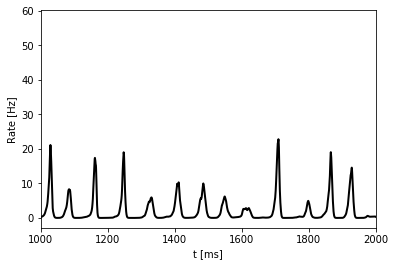

In [5]:
plt.plot(aln['t'], aln['rates_exc'].T, lw=2, c='k')
plt.xlabel("t [ms]")
plt.ylabel("Rate [Hz]")
plt.xlim(1000, 2000);

In [6]:
# all outputs are also available as an xarray DataArray
xr = aln.xr()
print(xr.dims)
# outputs can also be accessed via attributes in dot.notation
print("rates_exc", aln.rates_exc)

('output', 'space', 'time')
rates_exc [[0.37584923 0.37584923 0.37584923 ... 0.00132988 0.00125194 0.00118168]]


## BOLD model

In [7]:
# This block demonstrates how the BOLDModel class is interfaced inside the model.
# The BOLDModel in ALNModel is builtin, so technically you don't have to care about it.

In [8]:
from neurolib.models import bold
bold = bold.BOLDModel(aln.params['N'], aln.params['dt']) # we have to pass the number of nodes and dt of the neuronal model
bold.run(aln['rates_exc']) #

Text(0, 0.5, 'BOLD activity')

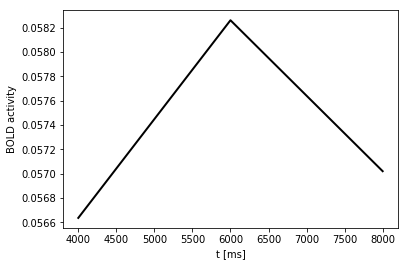

In [9]:
plt.plot(bold.t_BOLD[2:], bold.BOLD[:,2:].T, lw=2, c='k')
plt.xlabel("t [ms]")
plt.ylabel("BOLD activity")

# Whole brain model

## Load data

In [10]:
from neurolib.utils.loadData import Dataset
ds = Dataset("gw")

In [11]:
aln = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat, simulateBOLD=True) # simulates the whole-brain model in 10s chunks by default if simulateBOLD == True

In [12]:
# Resting state fits
aln.params['mue_ext_mean'] = 1.57
aln.params['mui_ext_mean'] = 1.6
aln.params['sigma_ou'] = 0.09
aln.params['b'] = 5.0

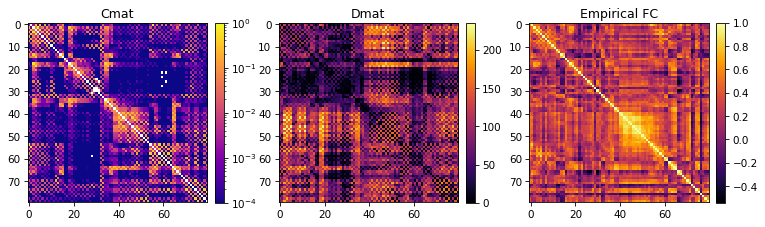

In [13]:
# Plotting data
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1, 3, figsize=(12,8), dpi=75)
fig.subplots_adjust(wspace=0.28)

im = axs[0].imshow(aln.params['Cmat'], norm=LogNorm(vmin=10e-5, vmax=np.max(aln.params['Cmat'])))
axs[0].set_title("Cmat")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
im = axs[1].imshow(aln.params['lengthMat'], cmap='inferno')
axs[1].set_title("Dmat")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
im = axs[2].imshow(ds.FCs[0], cmap='inferno')
axs[2].set_title("Empirical FC")
fig.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)

## Run model

In [14]:
aln.params['duration'] = 0.2.0*60*1000 
# info: value 0.2*60*1000 is low for testing
# use 5*60*1000 for real simulation
aln.run()

## Results

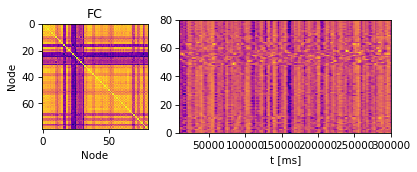

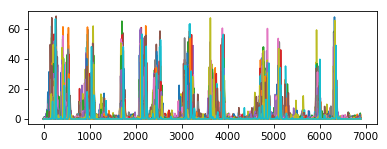

In [15]:
# Plot functional connectivity and BOLD timeseries (z-scored)
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=75, gridspec_kw={'width_ratios' : [1, 2]})
axs[0].imshow(func.fc(aln.BOLD.BOLD[:, 5:]))
axs[1].imshow(scipy.stats.mstats.zscore(aln.BOLD.BOLD[:, aln.BOLD.t_BOLD>10000], axis=1), aspect='auto', extent=[aln.BOLD.t_BOLD[aln.BOLD.t_BOLD>10000][0], aln.BOLD.t_BOLD[-1], 0, aln.params['N']]);

axs[0].set_title("FC")
axs[0].set_xlabel("Node")
axs[0].set_ylabel("Node")
axs[1].set_xlabel("t [ms]")

# the results of the model are also accesible through an xarray DataArray
fig, axs = plt.subplots(1, 1, figsize=(6, 2), dpi=75)
plt.plot(aln.xr().time, aln.xr().loc['rates_exc'].T);

In [28]:
scores = [func.matrix_correlation(func.fc(aln.BOLD.BOLD[:, 5:]), fcemp) for fcemp in ds.FCs]

print("Correlation per subject:", [f"{s:.2}" for s in scores])
print(f"Mean FC/FC correlation: {np.mean(scores):.2}")

Correlation per subject: ['0.34', '0.61', '0.54', '0.7', '0.54', '0.64', '0.69', '0.47', '0.59', '0.72', '0.58']
Mean FC/FC correlation: 0.58
